## Задача классификации на примере датасета wine-quality

In [177]:
import kaggle
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
os.getcwd()
# os.chdir('/environment/notebooks/DS PRojects')

'/environment/notebooks/DS PRojects'

In [2]:
name = 'rajyellow46/wine-quality'
destination = 'datasets'
%run scripts/ds_load.py {name} {destination}

In [3]:
df = pd.read_csv('datasets/winequalityN.csv')
df.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
df[['quality', 'type']].nunique()

quality    7
type       2
dtype: int64

In [7]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Сильный дисбаланс классов

/tmp/ipykernel_30/1865469051.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

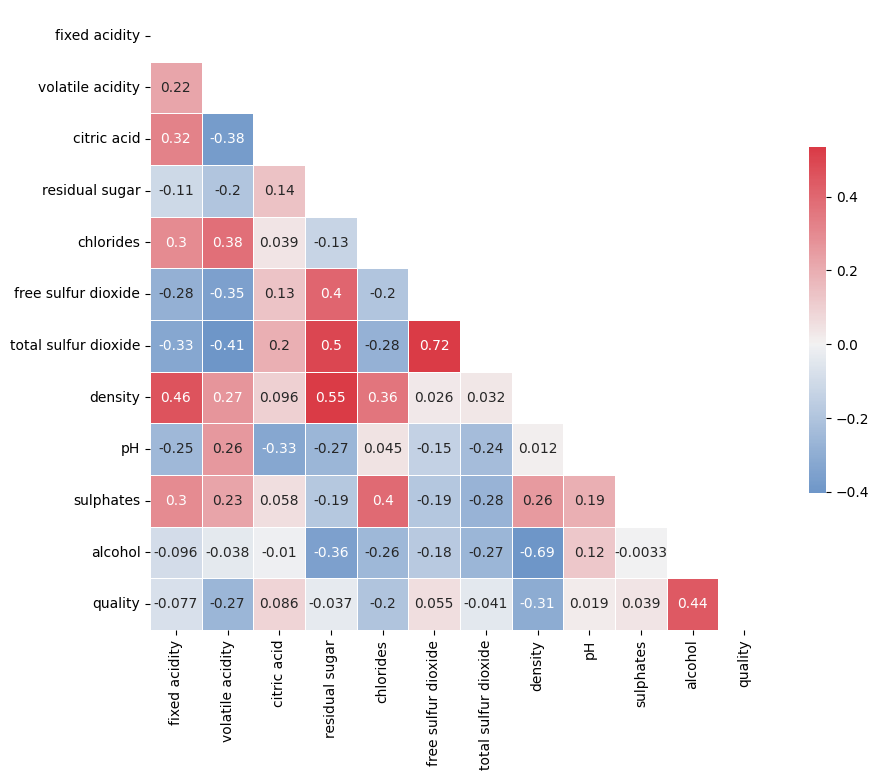

In [4]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 9))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, robust = True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Есть несколько скореллированных признаков. На работу random forest повлиять не должны

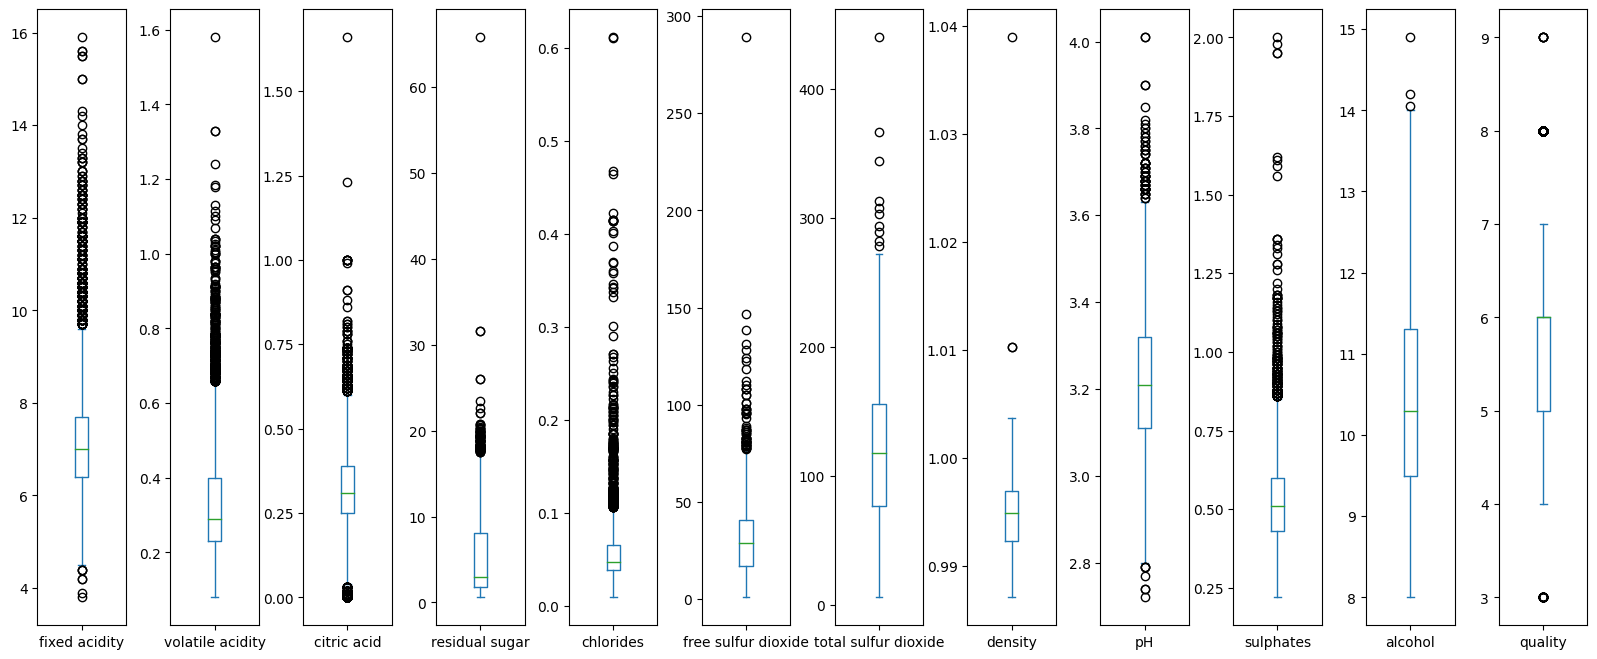

In [5]:
df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(20, 8))

plt.subplots_adjust(wspace=0.5) 
plt.show()

базовая модель - Дерево решений с настройками по умолчанию. 
Без предобработки данных кроме one-hot кодирования столбца type и заполнения нулевых значений.

In [6]:
df = pd.get_dummies(df, columns = ['type'], drop_first = True)

In [7]:
X = df.drop(['quality'], axis = 1)
y = df['quality']

In [8]:
imp = IterativeImputer(max_iter=10, random_state=0)
X_imp = imp.fit_transform(X)

In [9]:
print(np.count_nonzero(np.isnan(X)),'\n', np.count_nonzero(np.isnan(X_imp)))

38 
 0


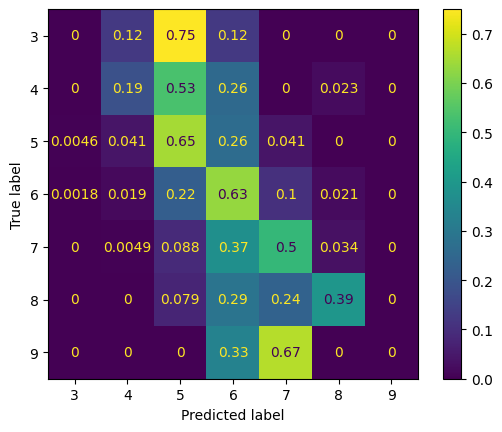


 train score: 1.0 
 test score: 0.5892307692307692 

Decision Tree report: 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.21      0.19      0.20        43
           5       0.61      0.65      0.63       435
           6       0.63      0.63      0.63       569
           7       0.54      0.50      0.52       204
           8       0.43      0.39      0.41        38
           9       0.00      0.00      0.00         3

    accuracy                           0.59      1300
   macro avg       0.34      0.34      0.34      1300
weighted avg       0.58      0.59      0.59      1300



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state = 666)
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

dt.fit(X_train, y_train)
train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)
clf_rep = classification_report(y_test, dt.predict(X_test), zero_division = 0)
   
predictions = dt.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels = dt.classes_, normalize = 'true')
    
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=dt.classes_)
    
disp.plot()
plt.show()
print('\n', 'train score:', dt.score(X_train, y_train), '\n',
        'test score:', dt.score(X_test, y_test), '\n')

print('Decision Tree report:', '\n'*2, clf_rep)

In [11]:
def random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 666)
    forest = RandomForestClassifier(random_state = 42,
                                    n_estimators = 500,
                                    class_weight = 'balanced',
                                    min_samples_split = 6,
                                    )
    forest.fit(X_train, y_train)
    train_score = forest.score(X_train, y_train)
    test_score = forest.score(X_test, y_test)
    clf_rep = classification_report(y_test, forest.predict(X_test), zero_division = 0)
    
    predictions = forest.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels = forest.classes_, normalize = 'true')
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=forest.classes_)
    
    disp.plot()
    plt.show()
    print('\n', 'train score:', forest.score(X_train, y_train), '\n',
        'test score:', forest.score(X_test, y_test), '\n')

    print('Random forest report:', '\n'*2, clf_rep)

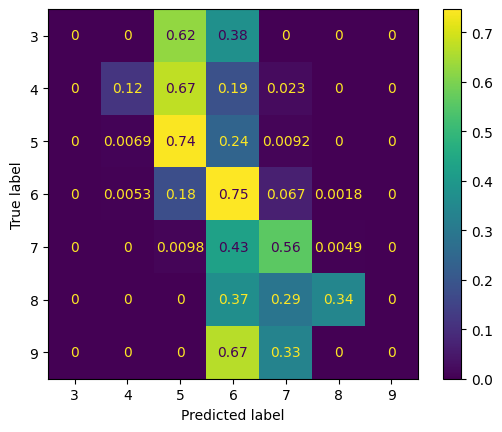


 train score: 0.9982682316721185 
 test score: 0.676923076923077 

Random forest report: 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.45      0.12      0.19        43
           5       0.70      0.74      0.72       435
           6       0.66      0.75      0.70       569
           7       0.67      0.56      0.61       204
           8       0.87      0.34      0.49        38
           9       0.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.48      0.36      0.39      1300
weighted avg       0.67      0.68      0.66      1300



In [12]:
random_forest(X_imp, y)

Данные несбалансированы. Модель не смогла предсказать классы 3 и 9. 

In [13]:
# Устранение дисбаланса классов при помощи SMOTE
sm = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=4, n_jobs=None)
X_res, y_res = sm.fit_resample(X_imp, y)

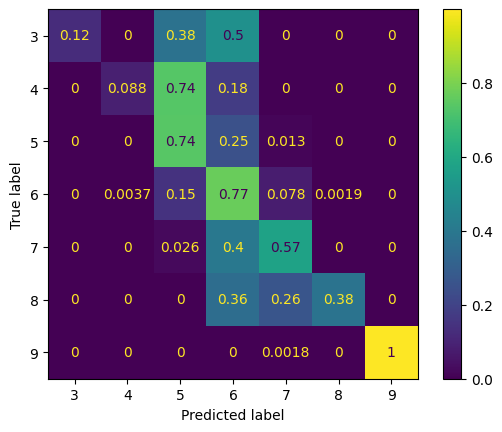


 train score: 0.9977217904047172 
 test score: 0.7834941050375134 

Random forest report: 

               precision    recall  f1-score   support

           3       1.00      0.12      0.22         8
           4       0.60      0.09      0.15        34
           5       0.74      0.74      0.74       445
           6       0.64      0.77      0.70       538
           7       0.69      0.57      0.63       232
           8       0.94      0.38      0.54        42
           9       1.00      1.00      1.00       567

    accuracy                           0.78      1866
   macro avg       0.80      0.52      0.57      1866
weighted avg       0.79      0.78      0.78      1866



In [14]:
random_forest(X_res, y_res)

уберем скореллированные признаки и попробуем еще раз

In [15]:
X2 = df.drop(['total sulfur dioxide', 'density', 'quality'], axis = 1)
y2 = df['quality']

In [16]:
X2_imp = imp.fit_transform(X2)
X2_res, y2_res = sm.fit_resample(X2_imp, y2)

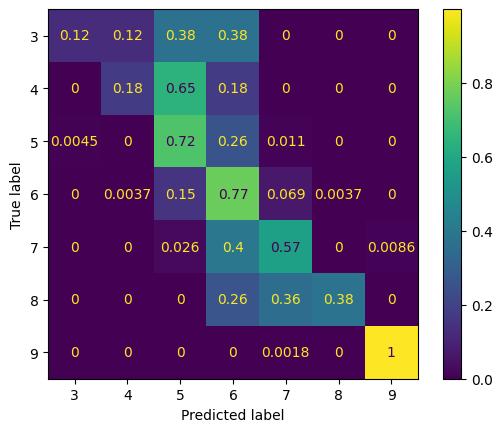


 train score: 0.9969177164299116 
 test score: 0.7808145766345124 

Random forest report: 

               precision    recall  f1-score   support

           3       0.33      0.12      0.18         8
           4       0.67      0.18      0.28        34
           5       0.74      0.72      0.73       445
           6       0.64      0.77      0.70       538
           7       0.69      0.57      0.63       232
           8       0.89      0.38      0.53        42
           9       1.00      1.00      1.00       567

    accuracy                           0.78      1866
   macro avg       0.71      0.53      0.58      1866
weighted avg       0.78      0.78      0.78      1866



In [17]:
random_forest(X2_res, y2_res)

Результат стал незначительно хуже